In [15]:
import math
import sqlite3
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import relativedelta

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15,10)})

In [2]:
#Read the inpu tdata files
df_ord = pd.read_csv('./data/bl_fulfillment_orders.csv')
#In the bl_fulfillment_orders table orders of type “inventory” and type “shopify” are the same thing.
#Substitute inventory with 'shopify'
df_ord['order_type'] = df_ord['order_type'].apply(lambda x: 'shopify' if x=='inventory' else x)
df_ord['created_at'] = pd.to_datetime(df_ord['created_at'])
df_ord['created_date'] = pd.to_datetime(df_ord['created_at'].dt.strftime('%Y-%m-%d'))
df_ord['user_type'] = df_ord['user_id'].apply(lambda x: 'users' if not math.isnan(x) else 'non-users')
print('Read Orders:', df_ord.shape)
df_ord_items = pd.read_csv('./data/bl_fulfillment_order_items.csv')
df_ord_items['created_at'] = pd.to_datetime(df_ord_items['created_at'])
df_ord_items['created_date'] = pd.to_datetime(df_ord_items['created_at'].dt.strftime('%Y-%m-%d'))
print('Read Order Items:', df_ord_items.shape)
df_ord_states = pd.read_csv('./data/bl_fulfillment_order_states.csv')
df_ord_states['created_at'] = pd.to_datetime(df_ord_states['created_at'])
df_ord_states['created_date'] = pd.to_datetime(df_ord_states['created_at'].dt.strftime('%Y-%m-%d'))
print('Read Order States:', df_ord_states.shape)

Read Orders: (570071, 12)
Read Order Items: (825908, 7)
Read Order States: (1453355, 5)


In [3]:
#Add the 'is_bottles' flag to the order dataframe
ls_order_ids_bottles = df_ord_items[df_ord_items['name'].str.lower().str.contains('bottles')]['order_id'].unique().tolist()
df_ord['is_bottles'] = df_ord['id'].apply(lambda x: 'bottles' if x in ls_order_ids_bottles else 'regular')
df_ord['user_type_isbottles'] = df_ord['user_type'] + ':' + df_ord['is_bottles']
df_ord.head()

,id,purchaser_id,user_id,state,total,subtotal,tax,shipping,created_at,order_type,created_date,user_type,is_bottles,user_type_isbottles
0,174553,170816,NaN,shipped,90.97,90.97,0.00,0.00,2018-01-01 00:02:16,shopify,2018-01-01,non-users,regular,non-users:regular
1,174558,170821,NaN,shipped,37.38,35.95,1.43,0.00,2018-01-01 00:19:12,shopify,2018-01-01,non-users,regular,non-users:regular
2,174563,170826,1676888.0,shipped,0.00,0.00,0.00,0.00,2018-01-01 00:20:27,hello_baby_box,2018-01-01,users,regular,users:regular
3,174567,170830,NaN,shipped,14.98,10.99,0.00,3.99,2018-01-01 00:30:06,shopify,2018-01-01,non-users,regular,non-users:regular
4,174572,170835,1530699.0,shipped,32.65,29.99,2.66,0.00,2018-01-01 00:38:19,shopify,2018-01-01,users,regular,users:regular


In [4]:
df_ord_items.head()

,id,order_id,name,price,product_id,created_at,created_date
0,245164,174553,Love You Forever,4.99,1298.0,2018-01-01 00:02:16,2018-01-01
1,245169,174556,Boppy Bare Naked Pillow,29.99,3674.0,2018-01-01 00:12:38,2018-01-01
2,245173,174560,Babylist Hello Baby Box - January,0.00,23177.0,2018-01-01 00:20:09,2018-01-01
3,245178,174564,Goodnight Moon,6.99,1293.0,2018-01-01 00:27:33,2018-01-01
4,245182,174567,Dr. Seuss's Sleep Softly Book,10.99,18207.0,2018-01-01 00:30:06,2018-01-01


In [5]:
df_ord_states.head()

,id,order_id,state,created_at,created_date
0,506408,174552,open_order,2018-01-01 00:00:39,2018-01-01
1,506412,174557,completed,2018-01-01 00:15:51,2018-01-01
2,506416,174560,open_order,2018-01-01 00:20:09,2018-01-01
3,506420,174565,open_order,2018-01-01 00:28:26,2018-01-01
4,506424,174570,open_order,2018-01-01 00:30:27,2018-01-01


## Understand Order items and state of workflow for few orders


In [6]:
ls_order_ids = [174558,174553,174557,174572,796162,174712,796181,201297,173162]

In [7]:
df_ord[df_ord['id'].isin(ls_order_ids)].sort_values(by=['id','created_at'], 
                                                    ascending=[True,True])

,id,purchaser_id,user_id,state,total,subtotal,tax,shipping,created_at,order_type,created_date,user_type,is_bottles,user_type_isbottles
0,174553,170816,NaN,shipped,90.97,90.97,0.00,0.00,2018-01-01 00:02:16,shopify,2018-01-01,non-users,regular,non-users:regular
1496,174557,170820,NaN,completed,50.00,50.00,0.00,0.00,2018-01-01 00:15:48,electronic_gift_card,2018-01-01,non-users,regular,non-users:regular
1,174558,170821,NaN,shipped,37.38,35.95,1.43,0.00,2018-01-01 00:19:12,shopify,2018-01-01,non-users,regular,non-users:regular
4,174572,170835,1530699.0,shipped,32.65,29.99,2.66,0.00,2018-01-01 00:38:19,shopify,2018-01-01,users,regular,users:regular
32,174712,170971,1402673.0,shipped,261.74,240.19,21.55,0.00,2018-01-01 05:19:40,shopify,2018-01-01,users,regular,users:regular
20605,201297,197265,NaN,completed,15.00,15.00,0.00,0.00,2018-01-16 14:07:56,electronic_gift_card,2018-01-16,non-users,regular,non-users:regular
570060,796162,739852,3211169.0,open_order,72.25,65.99,6.26,0.00,2019-03-25 22:13:23,shopify,2019-03-25,users,regular,users:regular
565655,796181,739866,3376741.0,ordered,4.95,0.00,0.00,4.95,2019-03-25 22:20:33,hello_baby_box,2019-03-25,users,regular,users:regular


In [8]:
df_ord_items[df_ord_items['order_id'].isin(ls_order_ids)].sort_values(by=['order_id','created_at'], 
                                                                      ascending=[True,True])

,id,order_id,name,price,product_id,created_at,created_date
0,245164,174553,Love You Forever,4.99,1298.0,2018-01-01 00:02:16,2018-01-01
3216,245165,174553,"Brown Bear, Brown Bear, What Do You See?",5.99,1309.0,2018-01-01 00:02:16,2018-01-01
15743,245166,174553,Graco Pack 'n Play Playard On The Go - Stratus,79.99,16616.0,2018-01-01 00:02:16,2018-01-01
3217,245170,174557,Babylist Store Gift Card,50.00,19106.0,2018-01-01 00:15:48,2018-01-01
15744,245171,174558,Philips Avent Fast Bottle Warmer,35.95,15833.0,2018-01-01 00:19:12,2018-01-01
5,245187,174572,Boppy Bare Naked Pillow,29.99,3674.0,2018-01-01 00:38:19,2018-01-01
46,245379,174712,Roshambo Baby Shades Strap and Ear Adjuster Kit,1.80,21217.0,2018-01-01 05:19:40,2018-01-01
47,245383,174712,Copper Pearl Top Knot Hat - Willow,11.25,21292.0,2018-01-01 05:19:40,2018-01-01
48,245387,174712,Baby Banana Teether & Infant Training Toothbru...,7.64,3720.0,2018-01-01 05:19:40,2018-01-01
3261,245376,174712,"Babysoy Solid Footie Pants - Thunder, 3-6 Months",13.50,19454.0,2018-01-01 05:19:40,2018-01-01


In [9]:
df_ord_states[df_ord_states['order_id'].isin(ls_order_ids)].sort_values(by=['order_id','created_at'], 
                                                                        ascending=[True,True])

,id,order_id,state,created_at,created_date
133,506940,173162,cancelled,2018-01-01 21:54:06,2018-01-01
14588,506409,174553,open_order,2018-01-01 00:02:17,2018-01-01
3337,507923,174553,prepare_shipment,2018-01-02 15:30:52,2018-01-02
18410,508925,174553,prepare_shipment,2018-01-02 15:41:11,2018-01-02
4105,510995,174553,partially_shipped,2018-01-02 23:18:29,2018-01-02
19145,510997,174553,shipped,2018-01-02 23:19:03,2018-01-02
1,506412,174557,completed,2018-01-01 00:15:51,2018-01-01
14589,506413,174558,fraud hold added by system - card fails zip c...,2018-01-01 00:19:12,2018-01-01
16917,506414,174558,open_order,2018-01-01 00:19:12,2018-01-01
147,506996,174558,fraud hold removed by Scott Halcomb,2018-01-01 21:56:31,2018-01-01


### Objective: 
We care about our e-commerce revenue growth and supporting that growth with the right amount of operational investment. Poor operational execution 
    - carrying the wrong items, 
    - the wrong level of inventory 
    - and the timeliness in which we fulfill orders
negatively impacts the customer experience. Please address the following in your presentation:

● How healthy are our sales?
+ What’s our average daily order volume and how has it changed over time?
+ Are there any patterns that emerge from the order volatility?
+ What types of patterns do you notice about types or quantities of items ordered?
+ Analyze orders containing bottles. Are there any patterns/trends that you notice?
+ What is the breakdown of purchases from users vs non-users and how has this changed over time?

● How are we doing from an order fulfillment perspective?
+ How many orders are we shipping out on average?
+ For orders created within the last 30 days what’s the % of orders that shipped (state = ‘shipped’) within 12hrs, 12-24hrs, 24-48hrs, greater than 48hrs? And how does that change over time?
+ Is there a pattern on what is shipping out faster or slower than other items?

● Potentail Project Questions?
+ Cancelation rates over time
+ Average order/basket size $ over time - Products per transaction
+ Predict Fraud
+ Forecast sales
+ Product Item Preferences of Babylist users. Can potentially help with stocking inventory.
+ Can we find Retention rate of babylist users for different order types?
+ Find out the likelihood of a hold being placed on an order to be shipped? If there is a pattern to the fraud flagged orders eventually being shipped and if we can predict it with a high confidence, the model can reduce shipping time to customers? Can it? What is the average time saved?



## How Healthy are our Sales?

In [10]:
df_ord[['total','subtotal','tax','shipping']].sum()

total       3.187293e+07
subtotal    2.967095e+07
tax         1.166601e+06
shipping    9.732138e+05
dtype: float64

In [11]:
# What’s our average daily order volume and how has it changed over time?
print('Daily Order volume and other statistics:')
df_ord.groupby('created_date')['id'].count().describe()

Daily Order volume and other statistics:


count     449.000000
mean     1269.645880
std       538.626661
min       292.000000
25%      1043.000000
50%      1176.000000
75%      1456.000000
max      8988.000000
Name: id, dtype: float64

Text(0.5, 1.0, 'Order # over Time by order created date')

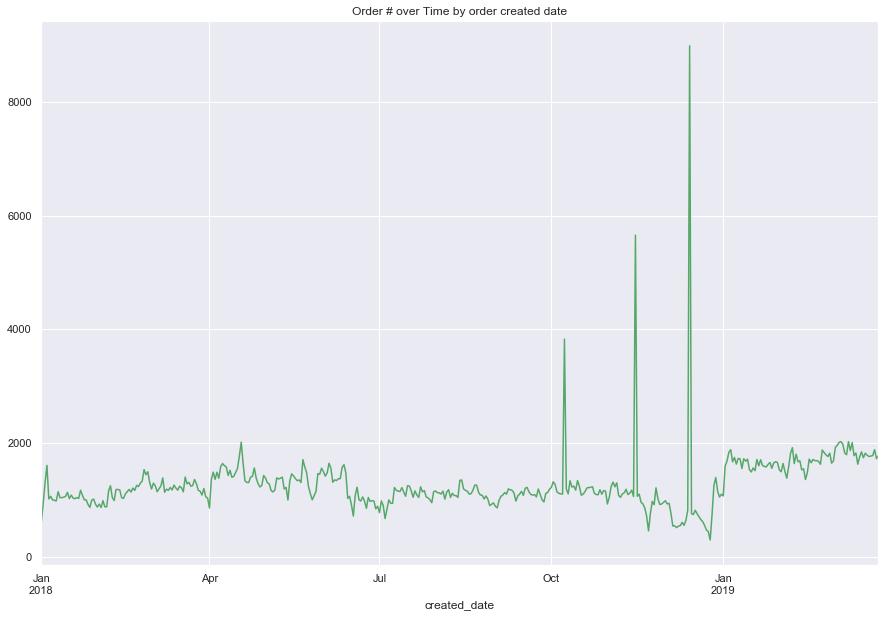

In [16]:
df_graph = df_ord.groupby('created_date')['id'].count().to_frame()
df_graph.rename(columns={'id':'order_counts'}, inplace=True)
df_graph['order_counts'].plot(color='g')
plt.title('Order # over Time by order created date')

Text(0.5, 1.0, '15/30 DMA of Order # over time by order created date')

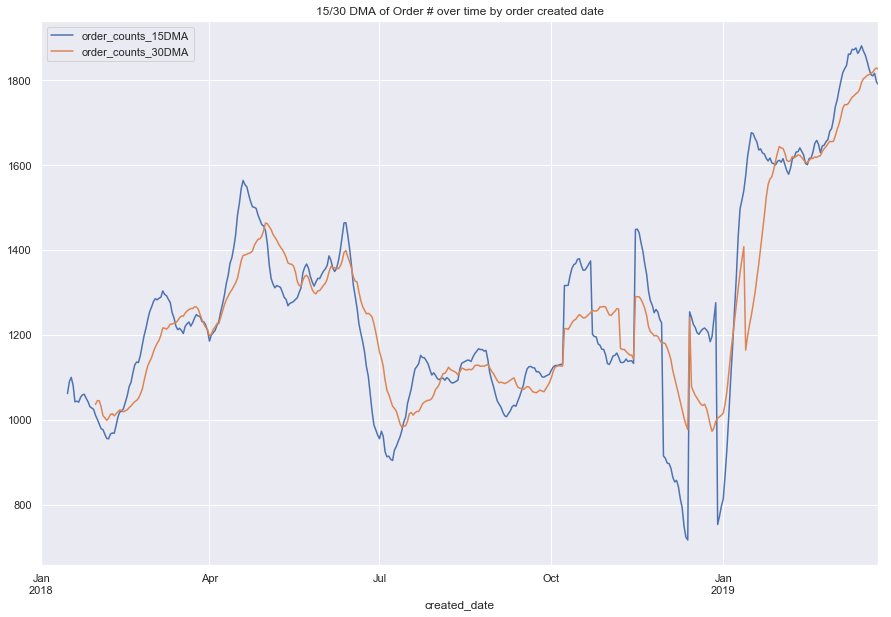

In [17]:
df_graph['order_counts_15DMA'] = df_graph['order_counts'].rolling(15).mean()
df_graph['order_counts_30DMA'] = df_graph['order_counts'].rolling(30).mean()
df_graph[['order_counts_15DMA','order_counts_30DMA']].plot()
plt.title('15/30 DMA of Order # over time by order created date')

In [18]:
df_graph[df_graph['order_counts'] > 2500]

,order_counts,order_counts_15DMA,order_counts_30DMA
created_date,,,
2018-10-08,3827,1316.866667,1215.166667
2018-11-15,5656,1448.800000,1291.000000
2018-12-14,8988,1254.933333,1241.900000


+ Order sales shows pretty consistent weekly sales with seasonal volatility during the holiday season in Q4 2018 peaking at ~9000 orders during week before Christmas. However, holiday season does seem to be pretty light for this type of business.

+ Order # seems to be average around 1200 orders a day before the holidays and around 1500 orders a day YTD.

Text(0.5, 1.0, 'Total Monthly $ Sales over Time')

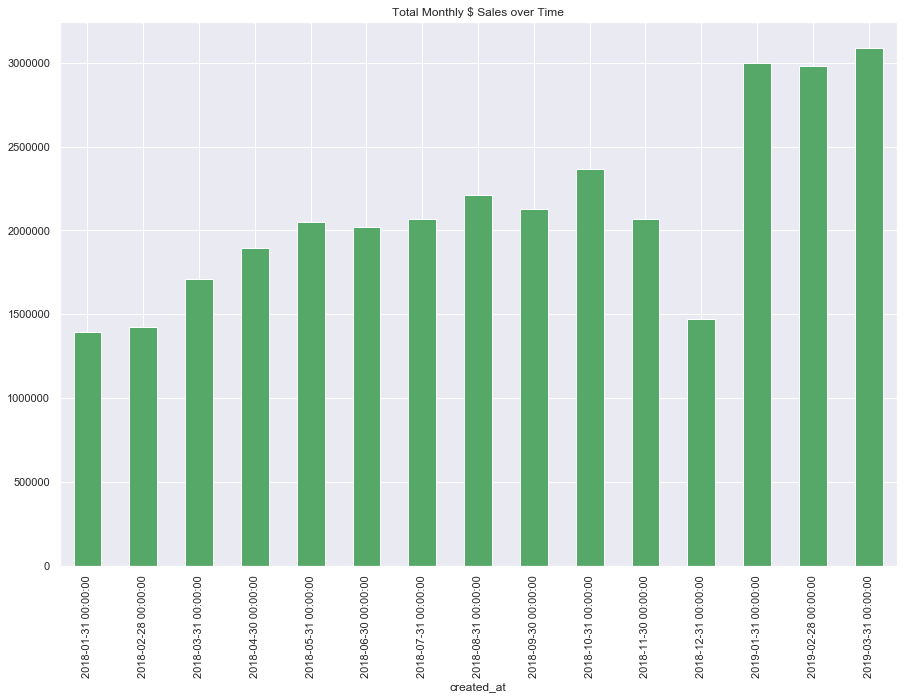

In [19]:
#How Healthy are our sales?
df_graph = df_ord.groupby(pd.Grouper(key='created_at', freq="M"))['total','shipping'].sum()
df_graph['total'].plot(color='g', kind='bar')
plt.title('Total Monthly $ Sales over Time')

+ Revenues have been growing YoY
+ Very interesting that there was actually a drop in sales during the holiday season. Thinking about it a little bit, it would seem that there are would be less demand for baby products during the holidays.

Text(0.5, 1.0, 'Shipping & Sales MoM growth percentage over Time')

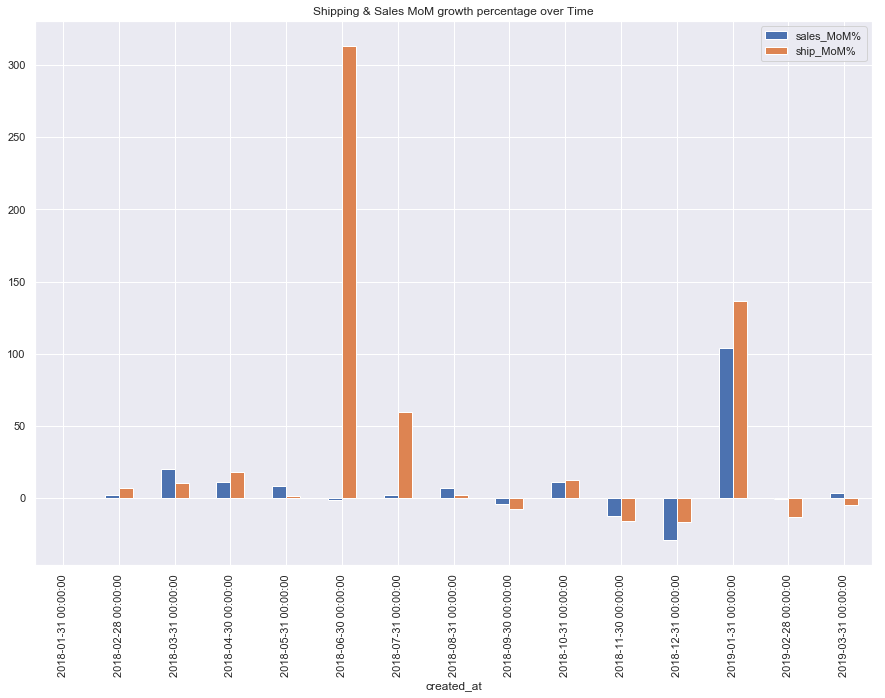

In [25]:
df_graph.rename(columns={'total':'sales'},inplace=True)
df_graph['sales_MoM%'] = (df_graph['sales']/df_graph['sales'].shift(1) - 1) * 100
df_graph['ship_MoM%'] = (df_graph['shipping']/df_graph['shipping'].shift(1) - 1) * 100
df_graph['sales_YoY%'] = (df_graph['sales']/df_graph['sales'].shift(12) - 1) * 100
df_graph['ship_YoY%'] = (df_graph['shipping']/df_graph['shipping'].shift(12) - 1) * 100
df_graph['ship/sales%'] = df_graph['shipping']/df_graph['sales'] * 100
df_graph[['sales_MoM%','ship_MoM%']].plot(kind='bar')

plt.title('Shipping & Sales MoM growth percentage over Time')

Text(0.5, 1.0, 'Shipping $ / Sales $ percentage over Time')

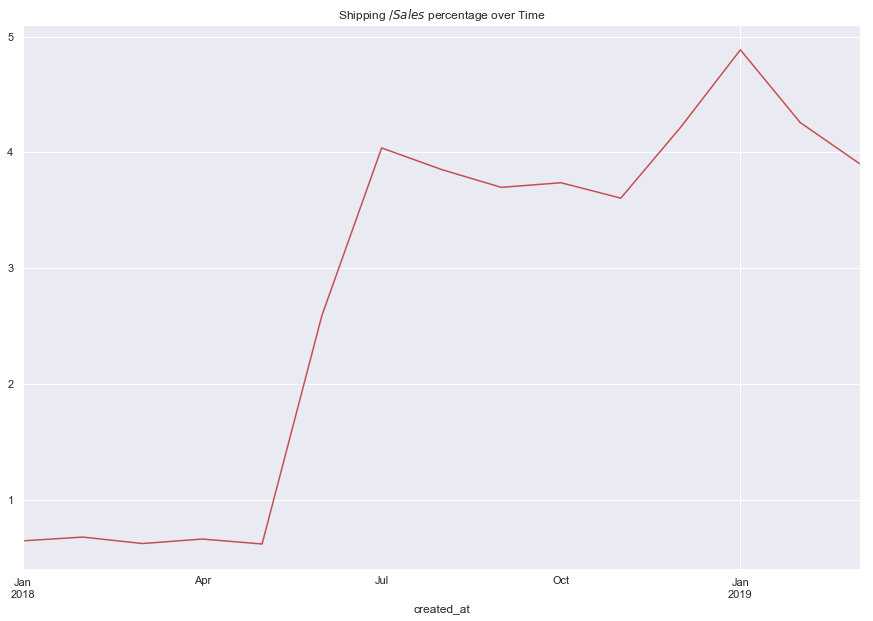

In [26]:
df_graph['ship/sales%'].plot(color='r')
plt.title('Shipping $ / Sales $ percentage over Time')

+ Revenues have been growing YoY at ~100% for the last 3 months. 
+ Cost of Shipping has grown faster than revenues however shipping costs to sales revenues have remained at a manageable 4% range since significant volume of sales started in June 2018. 
+ Indicates efficiency in shipping for incremental dollar sale recieved.
+ Business is Healthy and Growing at fast clip.

In [27]:
df_graph[df_graph.index > '2018-06-30']

,sales,shipping,sales_MoM%,ship_MoM%,sales_YoY%,ship_YoY%,ship/sales%
created_at,,,,,,,
2018-07-31,2.068587e+06,83539.98,2.461561,59.748342,NaN,NaN,4.038505
2018-08-31,2.213240e+06,85258.30,6.992863,2.056883,NaN,NaN,3.852193
2018-09-30,2.128407e+06,78708.75,-3.832991,-7.682009,NaN,NaN,3.698012
2018-10-31,2.365964e+06,88437.51,11.161232,12.360455,NaN,NaN,3.737907
2018-11-30,2.070524e+06,74637.90,-12.487054,-15.603798,NaN,NaN,3.604782
2018-12-31,1.471163e+06,62032.07,-28.947343,-16.889315,NaN,NaN,4.216534
2019-01-31,2.999296e+06,146548.11,103.872483,136.245719,115.330507,1532.082444,4.886084
2019-02-28,2.979469e+06,126874.61,-0.661055,-13.424602,109.560855,1217.731449,4.258296
2019-03-31,3.089077e+06,120489.54,3.678766,-5.032583,80.673311,1034.069366,3.900504


In [28]:
# Are there any patterns that emerge from the order volatility?
# What types of patterns do you notice about types or quantities of items ordered?
ls_group = ['created_date','order_type']
df_ord_volume = df_ord.groupby(ls_group).agg({'id':'count'})
df_ord_volume.rename(columns={'id':'order_counts'},inplace=True)
df_ord_volume_pct = df_ord_volume.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
df_ord_volume_pct = df_ord_volume_pct.reset_index()
df_ord_volume = df_ord_volume.reset_index()

Text(0.5, 1.0, 'Order Type composition % over Time')

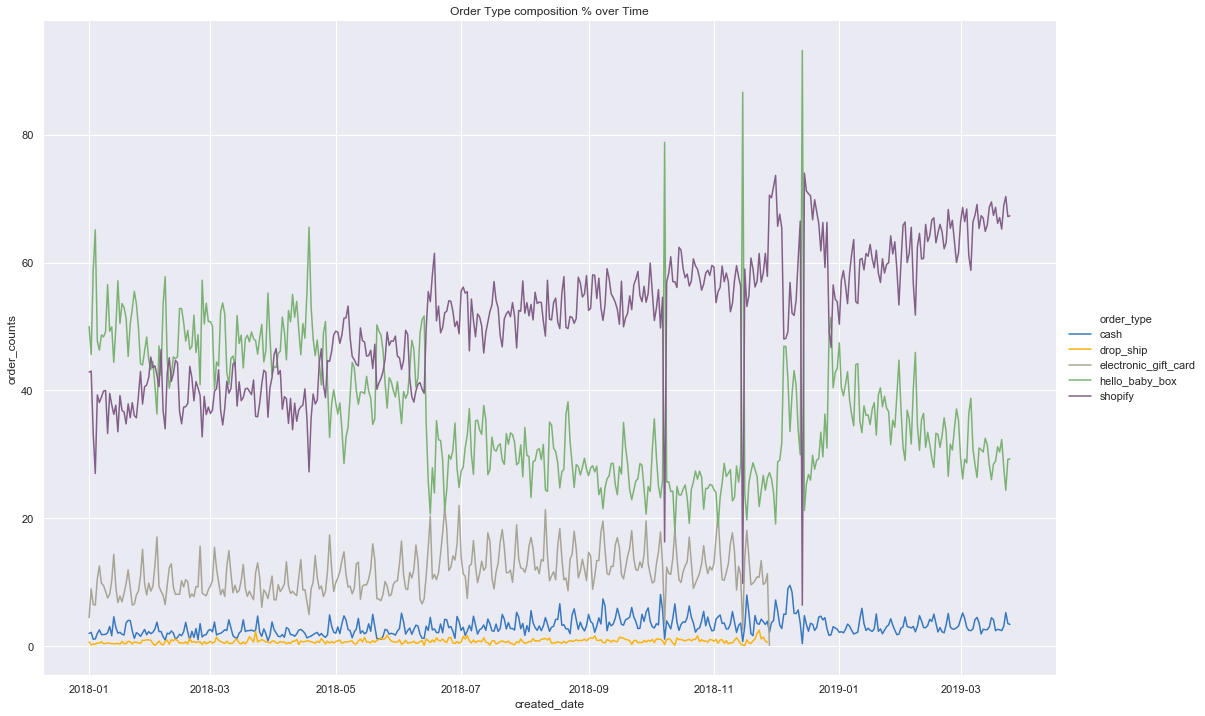

In [29]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
palette = sns.xkcd_palette(colors)
#df_ord_volume_pct = df_ord_volume_pct[]
sns.relplot(data=df_ord_volume_pct,x='created_date',y='order_counts', hue="order_type", 
            kind="line", height=10, aspect=1.5, palette=palette)
plt.title('Order Type composition % over Time')

+ When we decompose the overall sales trend into the % of different types of orders being ordered in a given day, the trend becaomes very volatile for 'hello baby box' and 'shopify' orders.
+ 'drop ship' orders are the ones being ordered the least at about 1% of the orders being ordered in a day and seemed to have stopped transactions since Dec 2018.
+ 'cash' orders are pretty stable around 3% of the overall order numbers

Text(0.5, 1.0, 'Order type composition % over time - 15 day moving average')

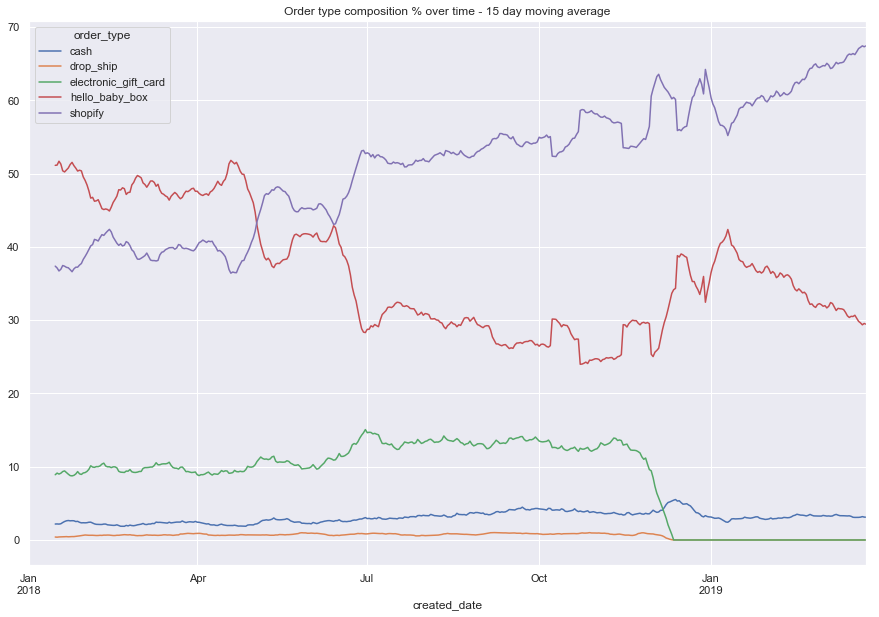

In [30]:
df_ord_volume_pct.pivot_table(values='order_counts', index=['created_date'],
                              columns=['order_type'], fill_value=0).rolling(15).mean().plot()
plt.title('Order type composition % over time - 15 day moving average')

Since Jan 2018, plotting a 15 day moving average of order type composition % in day reflects:
+ a growing business type of 'shopify' orders over time from ~40 to 70%
+ where as a declining business type 'hello baby box' orders over time from ~50% to 30%

However,
+ During the holiday period though shows the 'hello baby boxes' were performing much better rate than 'shopify' business.

Electronic gift cards seemed to be a pretty good segment till it was completely shut down?


In [31]:
#Find the number of items ordered and join it to the order. Then find the units per order in a given day.
df_ord_unit_cnt = df_ord_items.groupby('order_id')['product_id'].count().reset_index()
df_ord_unit_cnt.rename(columns={'product_id':'product_counts'}, inplace=True)
df_ord_merge = pd.merge(df_ord,df_ord_unit_cnt, how='left',left_on=['id'], right_on=['order_id'])
df_ord_merge = df_ord_merge.drop(labels=['order_id'],axis=1)
 
ls_group = ['created_date', 'order_type', 'user_type']
df_ppo = df_ord_merge.groupby(ls_group).agg({'id':'count','total':'sum','product_counts':'sum'})
df_ppo.rename(columns={'id':'order_counts','total':'sales'},inplace=True)
df_ppo['ppo'] = (df_ppo['product_counts']/df_ppo['order_counts']).round(2)
df_ppo = df_ppo.reset_index()

df_ppo.head()

,created_date,order_type,user_type,order_counts,sales,product_counts,ppo
0,2018-01-01,cash,non-users,12,1610.90,0.0,0.0
1,2018-01-01,drop_ship,non-users,2,368.00,2.0,1.0
2,2018-01-01,drop_ship,users,2,358.18,2.0,1.0
3,2018-01-01,electronic_gift_card,non-users,27,1970.00,27.0,1.0
4,2018-01-01,hello_baby_box,users,302,0.00,302.0,1.0


Text(0.5, 1.0, 'Swarm plot of PPO for different order types for users and non-users')

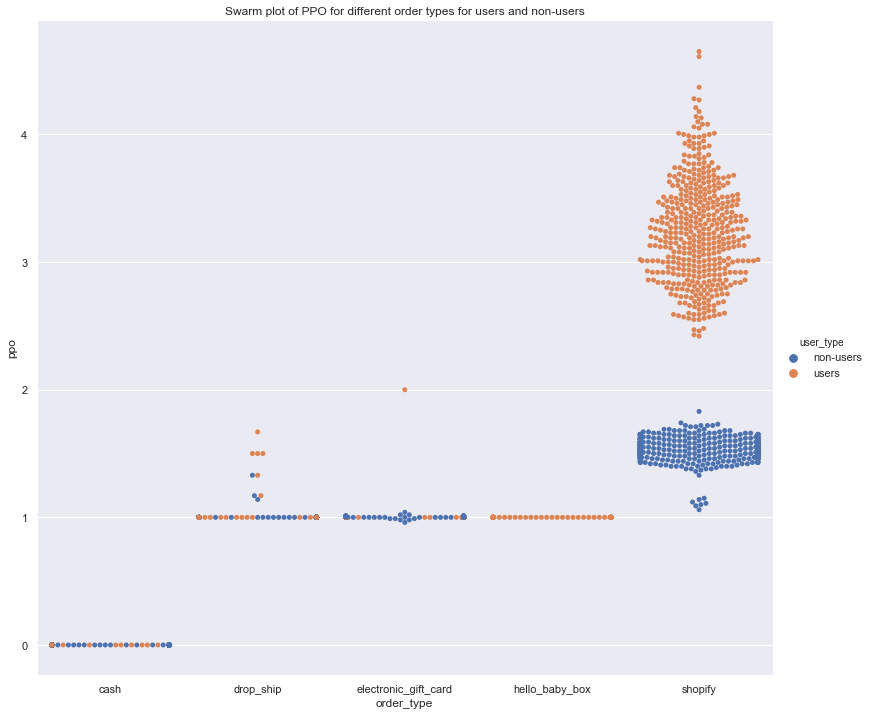

In [32]:
sns.catplot(x="order_type", y="ppo", data=df_ppo, kind='swarm', height=10, aspect=1.1, hue='user_type')
plt.title('Swarm plot of PPO for different order types for users and non-users')

Since Jan 2018,
+ Shopify orders tend to have higher products per order, averaging 1.9 products per order.
    + Babylist user ids with shopify orders tend to almost order double the products per order (~3.2 on average) versus
    + Babylist non-users (without an user id) with shopify orders tend to order ~1.5 products per order.
+ Drop ship, electronic gift card and hello baby box are all 1 product orders.

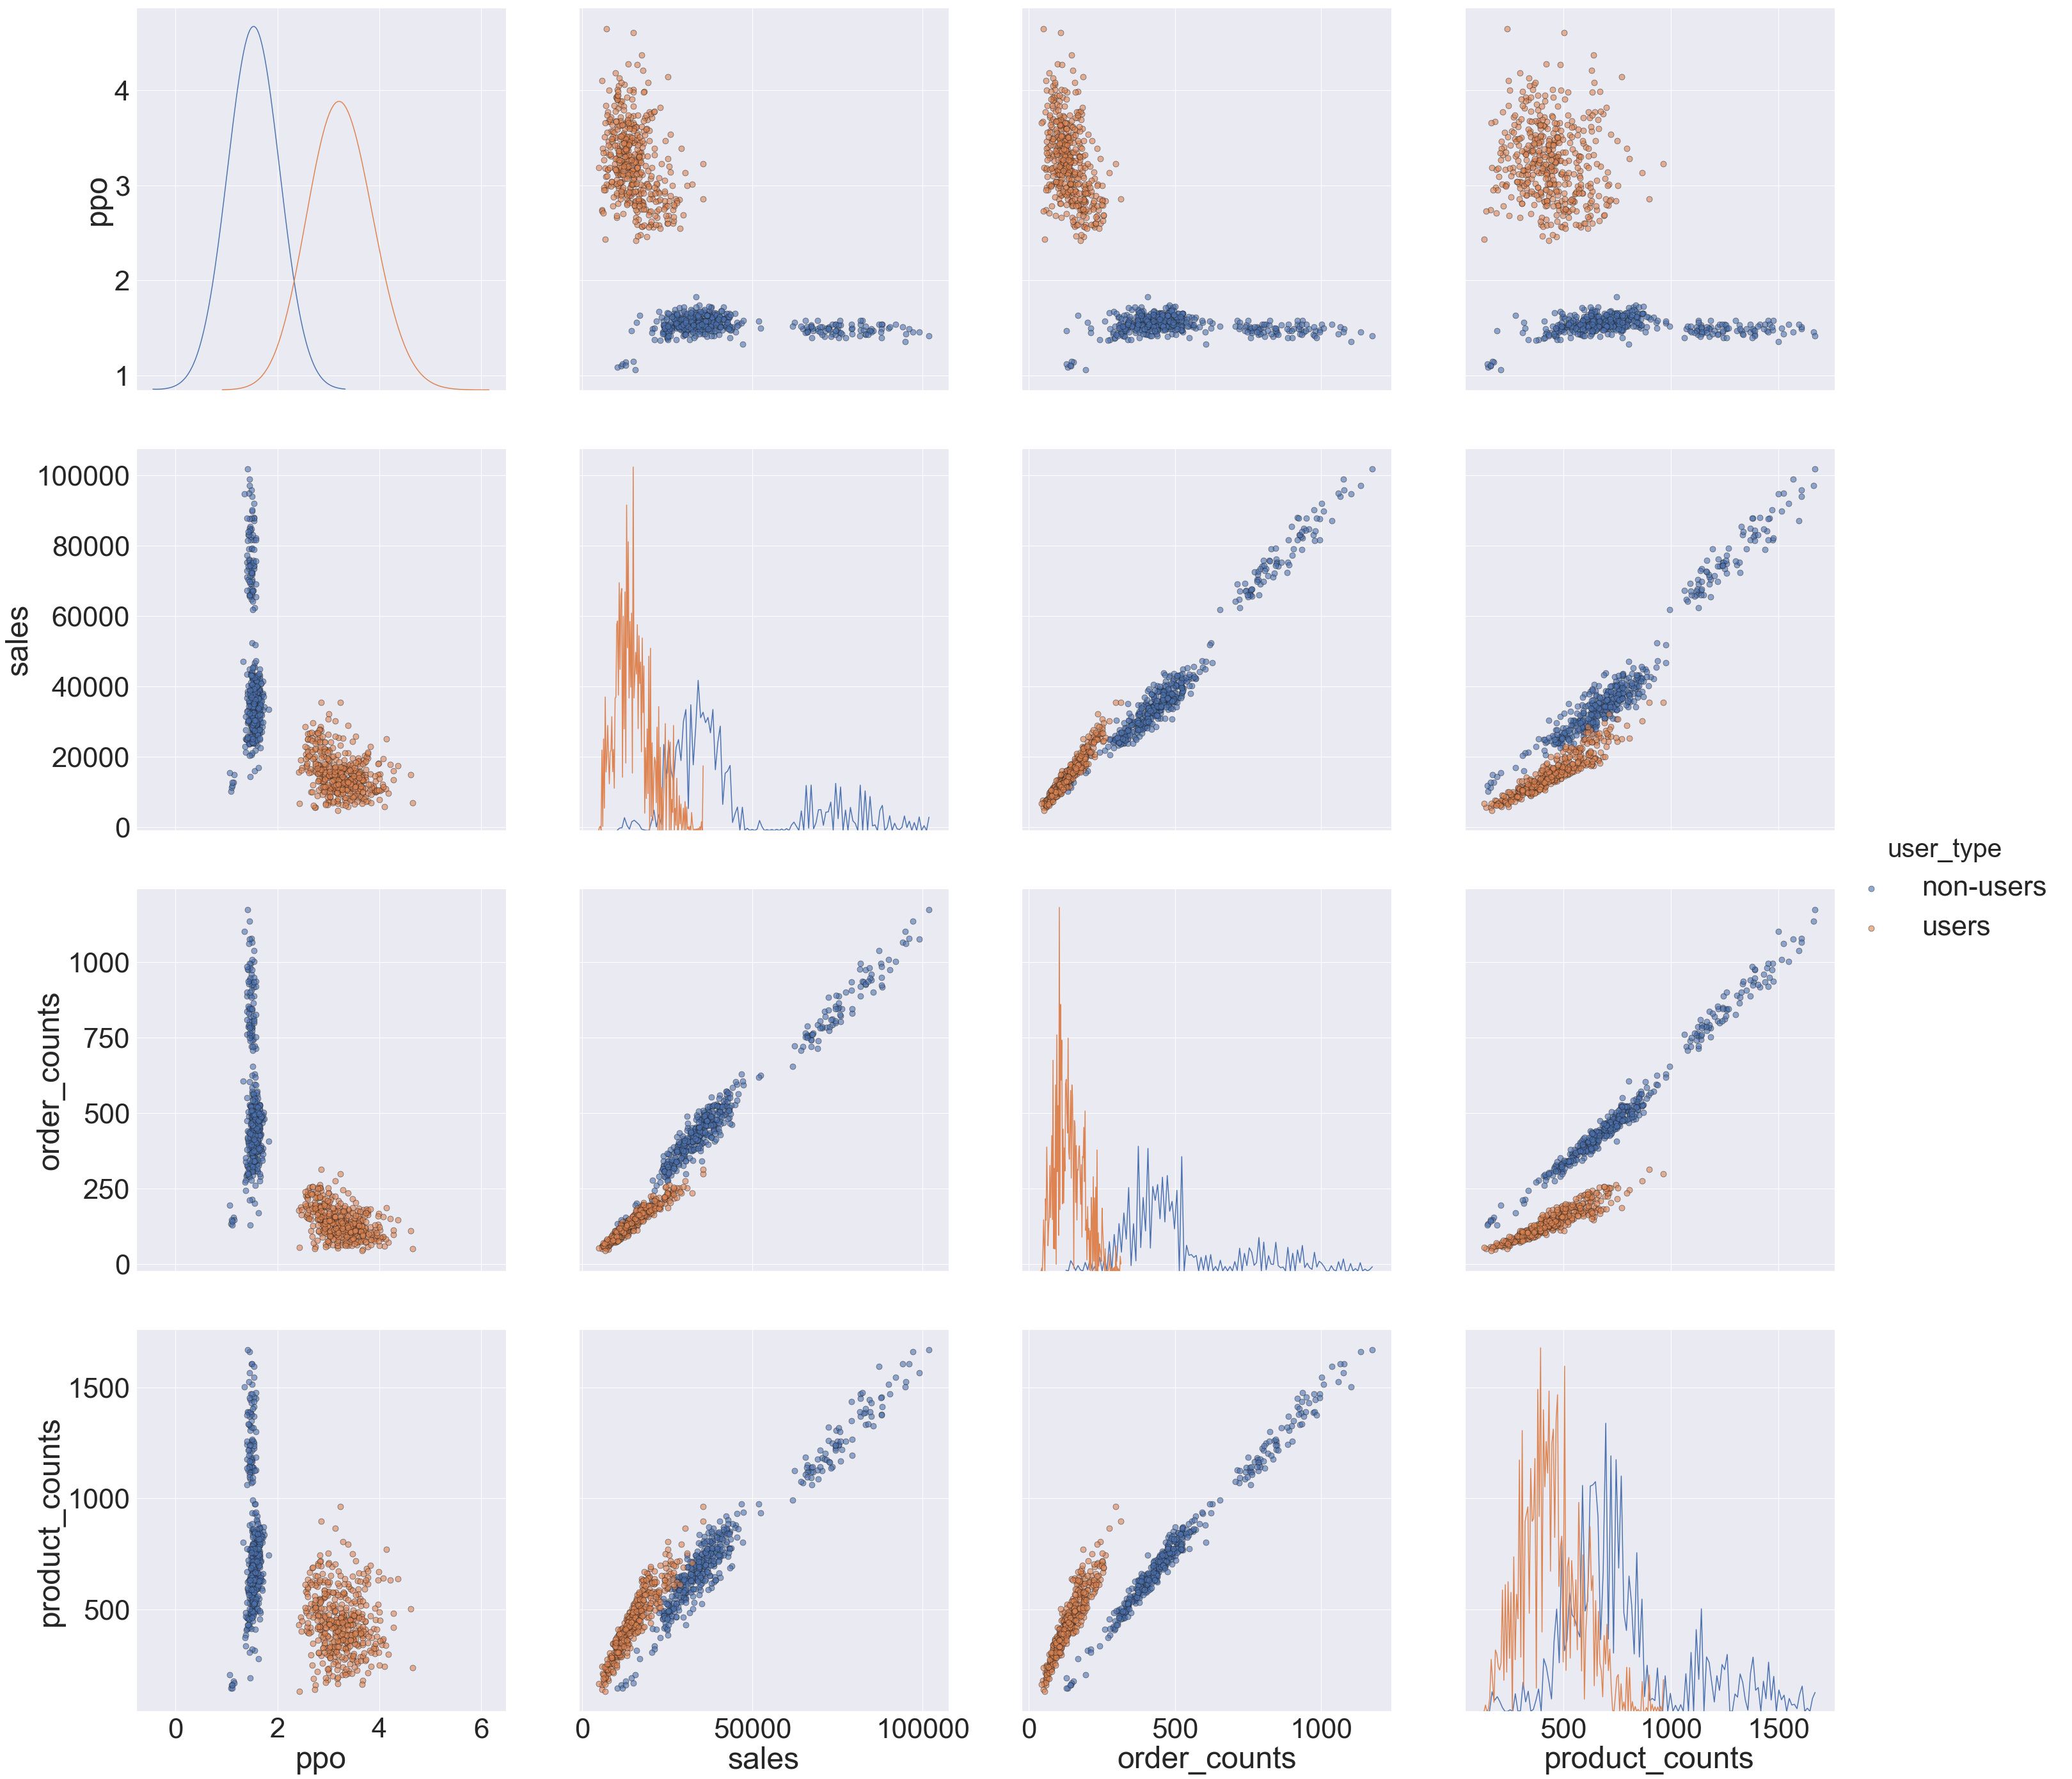

In [33]:
# Now that we have identified shopify as a segment of orders, let us dig a little bit deeper into that order type
sns.set(font_scale=4)
sns.set_style('darkgrid')
sns.pairplot(df_ppo[df_ppo['order_type'] == 'shopify'],
             vars = ['ppo', 'sales', 'order_counts','product_counts'], 
             hue = 'user_type', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 10, diag_kws={'bw':0.5,'shade':False})

Text(0.5, 1.0, 'Pair plot of Daily Sales $ and PPO for users and non-users')

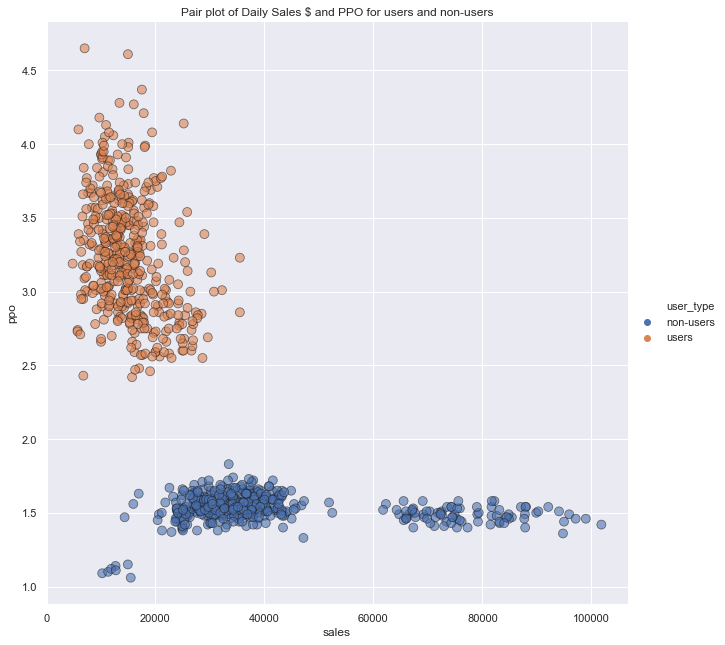

In [34]:
#Only for Shopify Orders
df_ppo_shopify = df_ppo[df_ppo['order_type'] == 'shopify']

sns.set(font_scale=1)
sns.set_style('darkgrid')
sns.relplot(data = df_ppo_shopify, x='sales', y='ppo', 
            hue='user_type', height=9, alpha= 0.6, s=80, edgecolor='k')
plt.title('Pair plot of Daily Sales $ and PPO for users and non-users')

Text(0.5, 1.0, 'Pair plot of Daily Order counts and Sales $ for users and non-users')

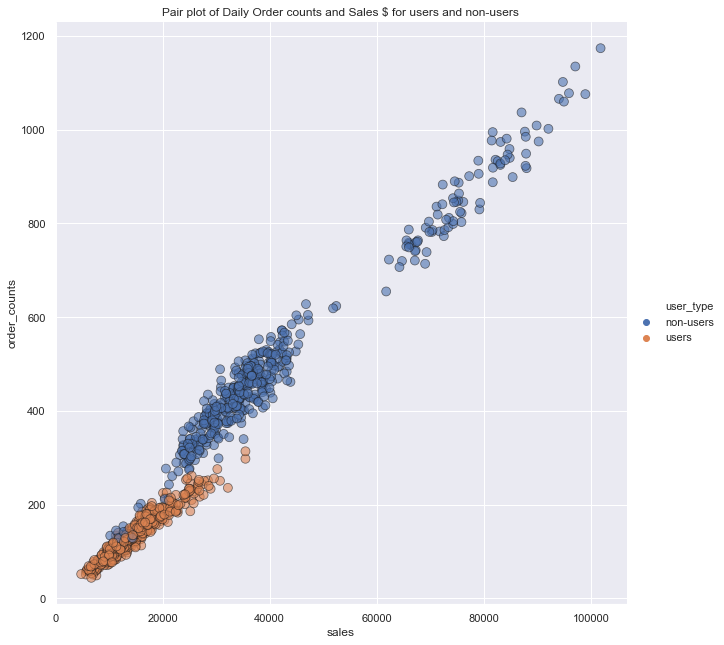

In [35]:
sns.set(font_scale=1)
sns.set_style('darkgrid')
sns.relplot(data = df_ppo_shopify, x='sales', y='order_counts', 
            hue='user_type', height=9, alpha= 0.6, s=80, edgecolor='k')
plt.title('Pair plot of Daily Order counts and Sales $ for users and non-users')

Text(0.5, 1.0, 'Pair plot of Daily Order counts and PPO for users and non-users')

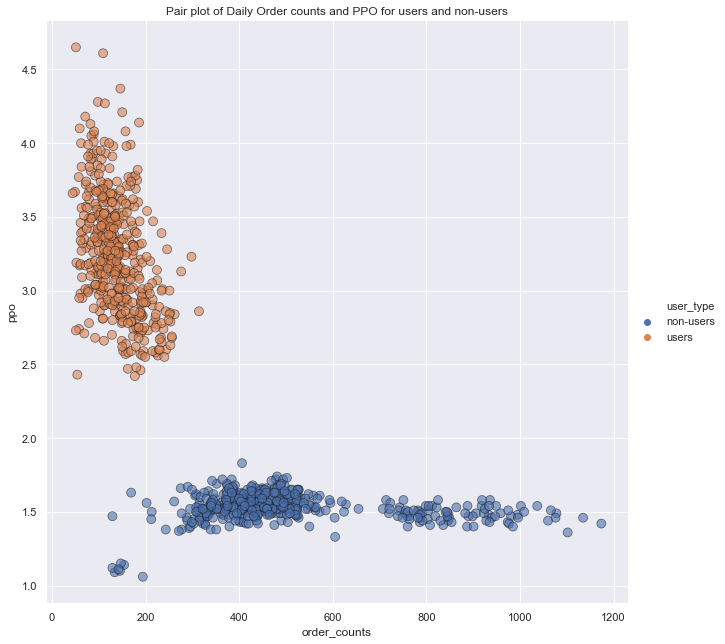

In [36]:
sns.set(font_scale=1)
sns.set_style('darkgrid')
sns.relplot(data = df_ppo_shopify, x='order_counts', y='ppo', 
            hue='user_type', height=9, alpha= 0.6, s=80, edgecolor='k')
plt.title('Pair plot of Daily Order counts and PPO for users and non-users')

+ Babylist non-users for shopfiy orders tend to order a lot and contribute a lot to sales but they are likely to order less products per order, an average of ~1.5.
+ Babylist users for shopfiy orders tend to order relatively less and contributed lesser to sales but they are likely to order more products per order, an average of ~3.2

In [37]:
# Analyze orders containing bottles. Are there any patterns/trends that you notice?

Text(0.5, 1.0, 'Swarm plot of PPO for different order types for users and non-users')

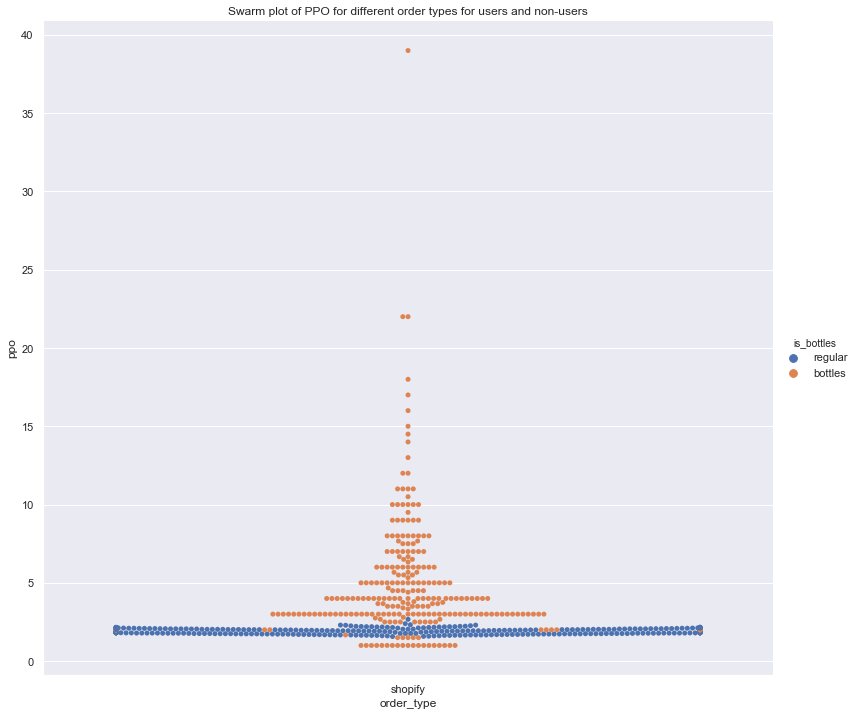

In [38]:
ls_group = ['created_date', 'order_type', 'is_bottles']
df_ppo = df_ord_merge.groupby(ls_group).agg({'id':'count','total':'sum','product_counts':'sum'})
df_ppo.rename(columns={'id':'order_counts','total':'sales'},inplace=True)
df_ppo['ppo'] = (df_ppo['product_counts']/df_ppo['order_counts']).round(2)
df_ppo = df_ppo.reset_index()
#Only for Shopify Orders
df_ppo_shopify = df_ppo[df_ppo['order_type'] == 'shopify']

sns.catplot(x="order_type", y="ppo", data=df_ppo_shopify, kind='swarm', height=10, aspect=1.1, hue='is_bottles')
plt.title('Swarm plot of PPO for different order types for users and non-users')

In [39]:
df_ppo_shopify.groupby(['is_bottles'])['ppo'].mean()

is_bottles
bottles    4.691942
regular    1.909065
Name: ppo, dtype: float64

Text(0.5, 1.0, 'Pair plot of Daily Order counts and PPO for users and non-users with or w/o bottles in orders')

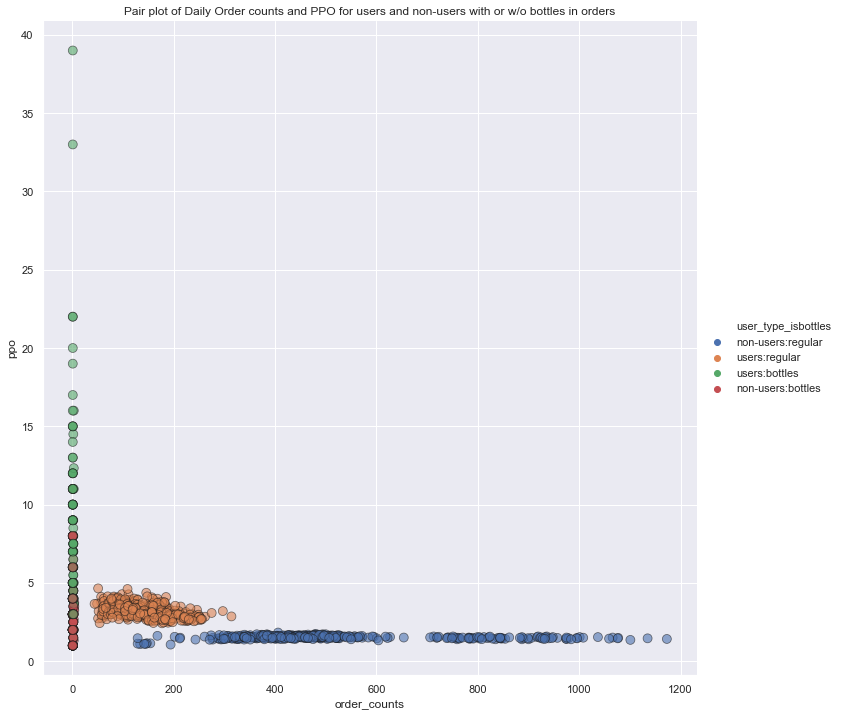

In [40]:
ls_group = ['created_date', 'order_type', 'user_type_isbottles']
df_ppo = df_ord_merge.groupby(ls_group).agg({'id':'count','total':'sum','product_counts':'sum'})
df_ppo.rename(columns={'id':'order_counts','total':'sales'},inplace=True)
df_ppo['ppo'] = (df_ppo['product_counts']/df_ppo['order_counts']).round(2)
df_ppo = df_ppo.reset_index()
#Only for Shopify Orders
df_ppo_shopify = df_ppo[df_ppo['order_type'] == 'shopify']

sns.set(font_scale=1)
sns.set_style('darkgrid')
sns.relplot(data = df_ppo_shopify, x='order_counts', y='ppo', 
            hue='user_type_isbottles', height=10, alpha= 0.6, s=80, edgecolor='k')
plt.title('Pair plot of Daily Order counts and PPO for users and non-users with or w/o bottles in orders')

In [41]:
df_ppo_shopify.groupby(['user_type_isbottles']).agg({'order_counts':'sum','sales':'sum','ppo':'mean'})

,order_counts,sales,ppo
user_type_isbottles,,,
non-users:bottles,247,14870.35,2.969840
non-users:regular,225860,18593956.46,1.531759
users:bottles,212,30373.33,6.680659
users:regular,62176,6723509.36,3.229688


+ Babylist user and non-users, when they order with bottles in their order, tend order a lot of items together and have a very high number of products per order, an average of ~4.69

+ Babylist users with bottles in their order have an average product per order of 6.68
+ Babylist non-users with bottles in their order have an average product per order of 2.96
+ Customers who are interested in bottles tend to buy a bunch of products around them.

From a value standpoint, we should leverage strategies to 
+ get non-users to sign up and become active users.

Text(0.5, 1.0, 'User type composition % of Order $ over time - 15 day moving average')

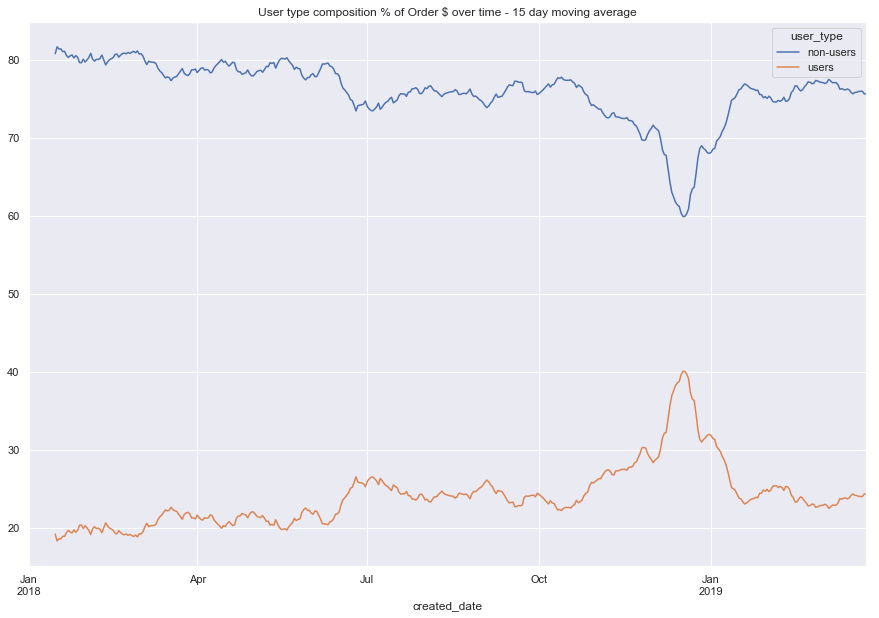

In [42]:
# What is the breakdown of purchases from users vs non-users and how has this changed over time?
ls_group = ['created_date','user_type']
df_ord_volume = df_ord.groupby(ls_group).agg({'total':'sum'})
df_ord_volume.rename(columns={'total':'order_total'},inplace=True)
df_ord_volume_pct = df_ord_volume.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
df_ord_volume_pct = df_ord_volume_pct.reset_index()
df_ord_volume = df_ord_volume.reset_index()

df_ord_volume_pct.pivot_table(values='order_total', index=['created_date'],
                              columns=['user_type'], fill_value=0).rolling(15).mean().plot()
plt.title('User type composition % of Order $ over time - 15 day moving average')

+ Non-users tend to be around be on an average 75% of Bablyist's transactions dollars.
+ User tend to be around 25% of Babylist's transaction dollars.
+ However, during the holidays, the users of Babylist tend to order more; reaching as high as 40% of the transaction dollars.

## How are we doing from an order fulfillment perspective?

On an average since Jan 2018, 1151.20 orders have been shipped a day.
YTD we have been shipping higher than historical average at 1696.99 orders a day


Text(0.5, 1.0, '# Orders shipped over time - 15 day moving average')

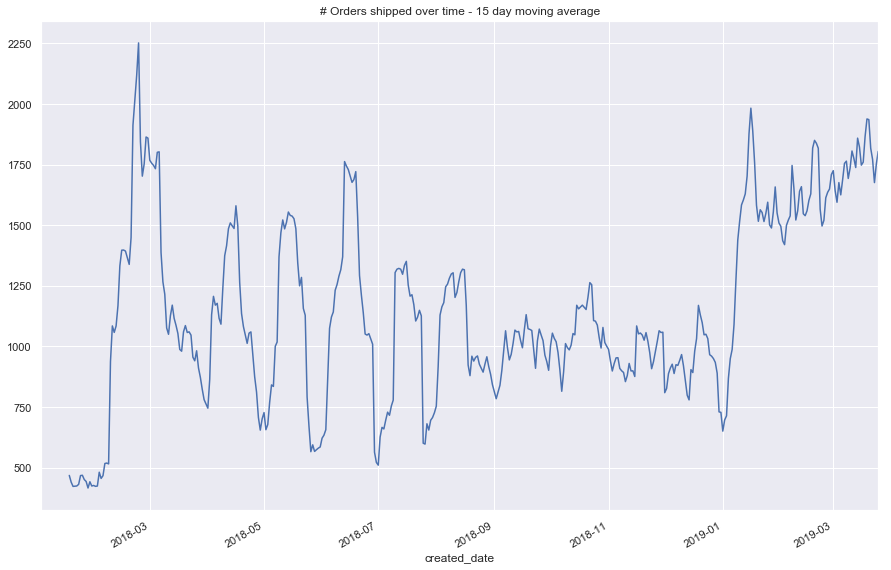

In [43]:
# How many orders are we shipping out on average?

# Filter out only the shipped order id's
df_ord_shipped = df_ord_states[df_ord_states['state'] == 'shipped']
d_avg_shipped = df_ord_shipped.groupby('created_date')['order_id'].count().mean()
print('On an average since Jan 2018, %0.2f orders have been shipped a day.' % d_avg_shipped)
df_ord_ship_cnt = df_ord_shipped.groupby('created_date')['order_id'].count()
d_ytd_avg_shipped = df_ord_ship_cnt[df_ord_ship_cnt.index >= '2019-01-01'].mean()
print('YTD we have been shipping higher than historical average at %0.2f orders a day' % d_ytd_avg_shipped)

df_ord_states[df_ord_states['state'] == 'shipped'].groupby('created_date')['order_id'].count().rolling(15).mean().plot()
plt.title('# Orders shipped over time - 15 day moving average')

+ On an average since Jan 2018, 1151.20 orders have been shipped a day.
+ YTD we have been shipping higher than historical average at 1696.99 orders a day

In [44]:
# For orders created within the last 30 days what’s the % of orders that shipped (state = ‘shipped’) 
# within 12hrs, 12-24hrs, 24-48hrs, greater than 48hrs? 
# And how does that change over time?

#Function to resolve the ship completion periods
def resolve_shp_completion_periods(ts):
    ts_1min = dt.timedelta(minutes=1)
    ts_12hours = dt.timedelta(hours=12)
    ts_24hours = dt.timedelta(hours=24)
    ts_48hours = dt.timedelta(hours=48)    
    
    if ts>=ts_1min and ts<ts_12hours:
        return '>0 to 12 hours'
    elif ts>=ts_12hours and ts<ts_24hours:
        return '>=12 to 24 hours'
    elif ts>=ts_24hours and ts<ts_48hours:        
        return '>=24 to 48 hours'
    elif ts>=ts_48hours:
        return '>=48 hours'    
    else:
        return '0 hours'

In [45]:
#Find the order id's of all the shipped order id's. 
ls_order_shipped = df_ord_shipped['order_id'].tolist()
df_shp_order_states = df_ord_states[df_ord_states['order_id'].isin(ls_order_shipped)]
df_shp_order_states = df_shp_order_states.sort_values(by=['created_date','order_id','created_at'],
                                                      ascending=[True,True,True])

In [46]:
df_shp_order_firsttime = df_shp_order_states.groupby('order_id').first()['created_at'].to_frame()
df_shp_order_firsttime.rename(columns={'created_at':'shp_start'},inplace=True)
df_shp_order_lasttime = df_shp_order_states.groupby('order_id').last()['created_at'].to_frame()
df_shp_order_lasttime.rename(columns={'created_at':'shp_end'},inplace=True)

df_shp_order_time = df_shp_order_firsttime.join(df_shp_order_lasttime)
df_shp_order_time['shp_delta'] = df_shp_order_time['shp_end'] - df_shp_order_time['shp_start']
df_shp_order_time['shp_days'] = df_shp_order_time['shp_delta'].dt.days
df_shp_order_time['shp_hours'] = df_shp_order_time['shp_delta'].dt.total_seconds()/3600

df_shp_order_time['shp_timespan'] = df_shp_order_time['shp_delta'].apply(resolve_shp_completion_periods)
df_shp_order_time = df_shp_order_time.reset_index()
df_shp_order_time['shp_date'] = pd.to_datetime(df_shp_order_time['shp_end'].dt.strftime('%Y-%m-%d'))

print('Ship Order shape:',df_shp_order_time.shape)
df_shp_order_time.head()
df_shp_order_time = pd.merge(df_shp_order_time, df_ord, how='inner',left_on=['order_id'],right_on=['id'])
df_shp_order_time = pd.merge(df_shp_order_time, df_ord_unit_cnt, how='inner',left_on=['order_id'],right_on=['order_id'])
#Get Created Week Start
df_shp_order_time['created_weekstart'] = df_shp_order_time['created_date'].dt.to_period('W').apply(lambda x: x.start_time)
#df_shp_order_time.drop('id',axis=1,inplace=True)
print('Ship Order shape:',df_shp_order_time.shape)

Ship Order shape: (504216, 8)
Ship Order shape: (501319, 24)


Text(0.5, 1.0, '% of Orders for different shipping timespans over time - 30 day moving average')

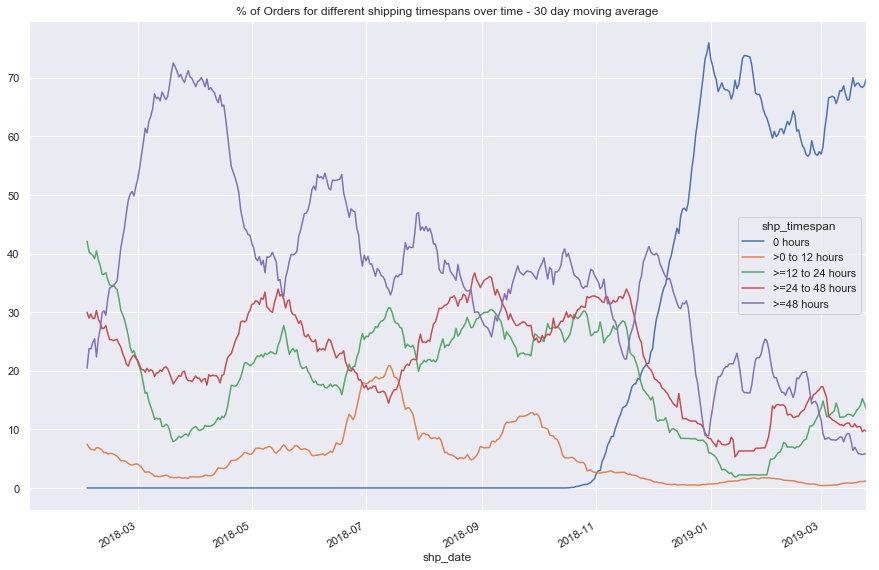

In [47]:
df_shp_order_time_dist = df_shp_order_time.groupby(['shp_date','shp_timespan'])['order_id'].count().to_frame()
df_shp_order_time_dist.rename(columns={'order_id':'order_counts'},inplace=True)
df_shp_order_time_dist['order_%'] = df_shp_order_time_dist.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))['order_counts']
df_shp_order_time_dist.reset_index()


df_shp_order_time_dist.pivot_table(values='order_%', index=['shp_date'],
                                   columns=['shp_timespan'], fill_value=0).rolling(30).mean().plot()
plt.title('% of Orders for different shipping timespans over time - 30 day moving average')

Text(0.5, 1.0, 'Box plot of days to ship % for different user types and order types')

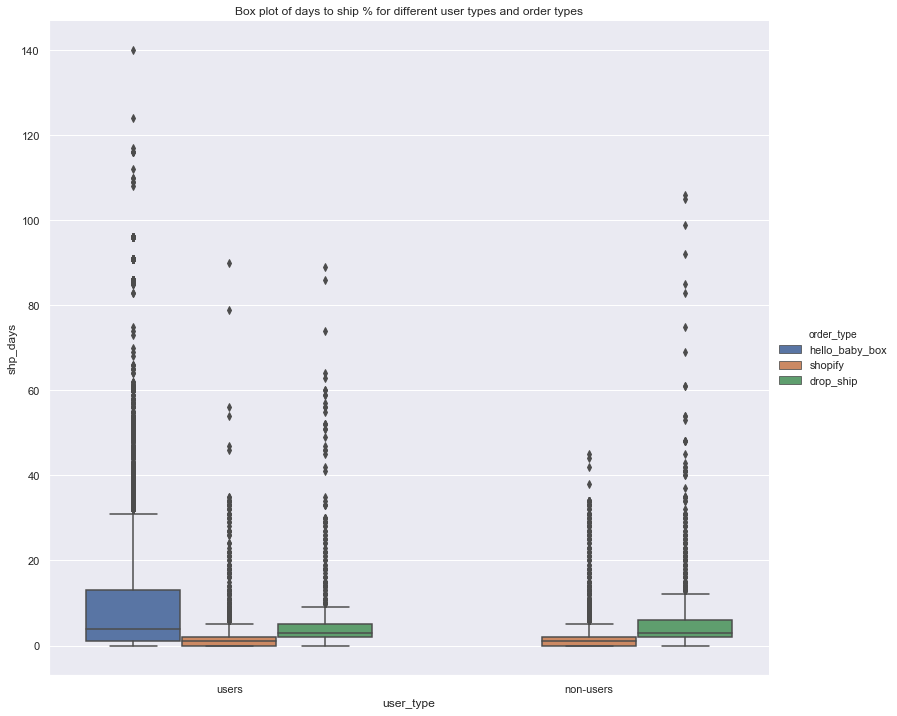

In [48]:
# Is there a pattern on what is shipping out faster or slower than other items?
sns.catplot(x="user_type", y="shp_days", data=df_shp_order_time[df_shp_order_time['shp_timespan'] != '0 hours'], 
            kind='box', height=10, aspect=1.1, hue='order_type')
plt.title('Box plot of days to ship % for different user types and order types')

Text(0.5, 1.0, 'Pair plot of total sales $ vs daily average shipping days for different order types')

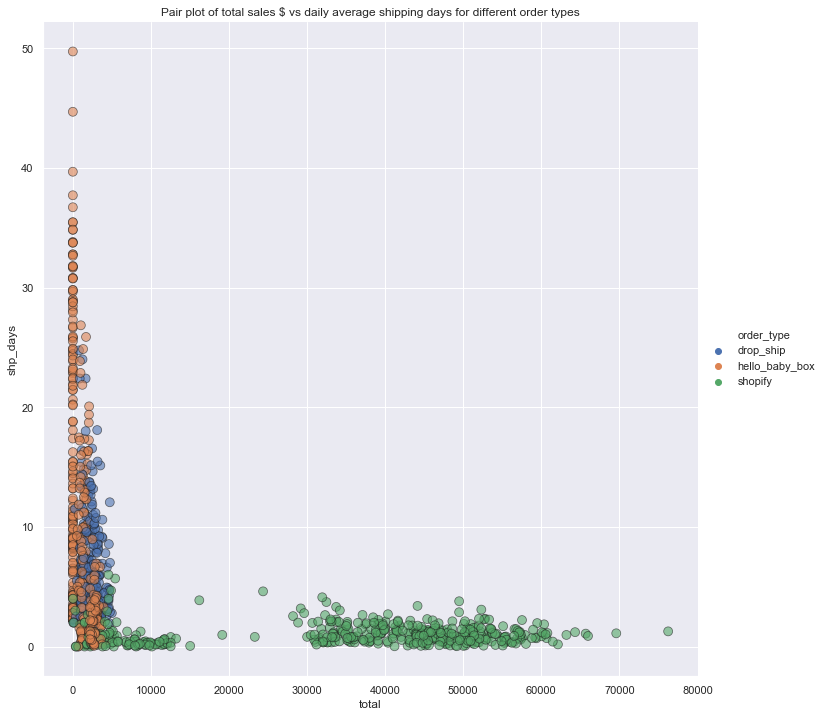

In [49]:
df_graph = df_shp_order_time[df_shp_order_time['shp_timespan'] 
                             != '0 hours'].groupby(['created_date',
                                                    'order_type']).agg({'shp_days':'mean',
                                                                        'total':'sum'}).reset_index()
sns.relplot(data = df_graph, x='total', y='shp_days', hue='order_type', height=10, alpha= 0.6, s=80, edgecolor='k')
plt.title('Pair plot of total sales $ vs daily average shipping days for different order types')

In [50]:
df_graph.groupby('order_type').agg({'shp_days':'mean','total':'sum'})

,shp_days,total
order_type,,
drop_ship,6.102262,752203.85
hello_baby_box,8.215371,517418.55
shopify,1.043357,15572065.24


+ % of Orders that have been shipped in >=48 hours has been steadily decreasing since Jan 2018. Down to ~8% since the highs of 70% last year.
+ Since December the drop in >=48 hours orders shipped coincides with the rise in the orders processed immediately (via some API?).
+ When we look at the plot of the sales to the average shipping days for different order types, 
    + we see that the shopify orders, contribute a lot to sales and their avg. shipped time is just a day
    + Contrast that tot the drop_ship & hello_baby_box orders that are in the 6-8 day range.
        + The hello_baby_box orders are also from the Babylist registered users.

## How are the cancellation orders faring?

Text(0.5, 1.0, '% of shipped and cancelled Orders over time - 15 day moving average')

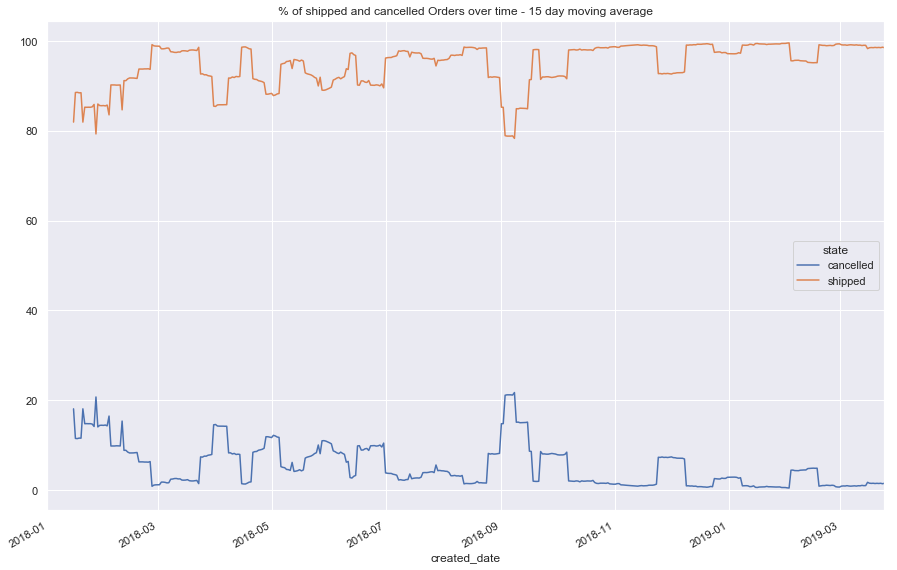

In [51]:
# What is their trend over time?
df_ord_shp_cancelled = df_ord_states[df_ord_states['state'].isin(['cancelled','shipped'])][['created_date',
                                                                                            'order_id','state']].drop_duplicates()

df_ord_shp_cancelled = df_ord_shp_cancelled.groupby(['created_date','state'])['order_id'].count().to_frame()
df_ord_shp_cancelled.rename(columns={'order_id':'order_counts'},inplace=True)
df_ord_shp_cancelled['order_%'] = df_ord_shp_cancelled.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))['order_counts']
df_ord_shp_cancelled = df_ord_shp_cancelled.reset_index()


df_ord_shp_cancelled.pivot_table(values='order_%', index=['created_date'],
                                 columns=['state'], fill_value=0).rolling(15).mean().plot()
plt.title('% of shipped and cancelled Orders over time - 15 day moving average')


In [52]:
df_ord_shp_cancelled.groupby(['state']).agg({'order_%':['mean','median']})

order_%           
                mean     median
state                          
cancelled   5.603792   1.051578
shipped    96.653725  98.994991

# How are the Monthly retention rates of Babylist users?

In [53]:
# Find the number of users that come again and again to buy. Retention rate in a monthly cohort.
df_ord_usrs = df_ord[~df_ord['user_id'].isnull()][['user_id','created_at','order_type']]
df_ord_usrs = df_ord_usrs.reset_index(drop=True)
df_ord_usrs['created_month'] = df_ord_usrs['created_at'].dt.to_period('M').dt.to_timestamp()

#Create the starting month cohort list for all user id's for each order type
df_coh_yrs = df_ord_usrs[['created_month',
                          'user_id','order_type']].sort_values(by=['user_id','order_type',
                                                                   'created_month'], ascending=[True,True,True])

df_coh_yrs = df_coh_yrs.drop_duplicates(subset=['user_id','order_type'])

#df_ord_usrs = df_ord_usrs.drop('created_date',axis=1)
print('Orders withe users shape:',df_ord_usrs.shape)

#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
df_ord_usrs.to_sql('ord_usrs', conn, index=False)
df_coh_yrs.to_sql('coh_yrs', conn, index=False)

qry = '''
    select
        coh_mon.created_month as base_month,
        coh_mon.order_type as base_order_type,
        coh_mon.user_id as base_user_id,
        trail.created_month as trail_month,
        trail.order_type as trail_order_type,
        trail.user_id as trail_user_id        
    from coh_yrs as coh_mon
    left join ord_usrs as trail on trail.user_id = coh_mon.user_id
                              and trail.created_month >= coh_mon.created_month
                              and trail.order_type = coh_mon.order_type
        
    '''
df_cohort = pd.read_sql_query(qry, conn)
df_cohort.head()
print('Cohort shape:',df_cohort.shape)

df_cohort.head()

Orders withe users shape: (282352, 4)
Cohort shape: (282352, 6)


,base_month,base_order_type,base_user_id,trail_month,trail_order_type,trail_user_id
0,2018-02-01 00:00:00,shopify,1.0,2018-02-01 00:00:00,shopify,1.0
1,2018-11-01 00:00:00,electronic_gift_card,2.0,2018-11-01 00:00:00,electronic_gift_card,2.0
2,2018-11-01 00:00:00,electronic_gift_card,2.0,2018-11-01 00:00:00,electronic_gift_card,2.0
3,2018-07-01 00:00:00,hello_baby_box,2.0,2018-07-01 00:00:00,hello_baby_box,2.0
4,2019-02-01 00:00:00,shopify,1255.0,2019-02-01 00:00:00,shopify,1255.0


In [61]:
df_base_counts = df_cohort.groupby(['base_month','base_order_type'])['base_user_id'].nunique().reset_index()
df_base_counts = df_base_counts.rename(columns={'base_user_id':'base_user_counts'})

df_trail_counts = df_cohort.groupby(['base_month','base_order_type','trail_month','trail_order_type'])['trail_user_id'].nunique().reset_index()
df_trail_counts = df_trail_counts.rename(columns={'trail_user_id':'trail_user_counts'})

df_coh_counts = pd.merge(df_base_counts,df_trail_counts,how='left',on=['base_month','base_order_type'])
df_coh_counts['base_month'] = pd.to_datetime(df_coh_counts['base_month'])
df_coh_counts['trail_month'] = pd.to_datetime(df_coh_counts['trail_month'])
df_coh_counts.head()

,base_month,base_order_type,base_user_counts,trail_month,trail_order_type,trail_user_counts
0,2018-01-01,cash,6,2018-01-01,cash,6
1,2018-01-01,drop_ship,63,2018-01-01,drop_ship,63
2,2018-01-01,drop_ship,63,2018-05-01,drop_ship,1
3,2018-01-01,electronic_gift_card,16,2018-01-01,electronic_gift_card,16
4,2018-01-01,electronic_gift_card,16,2018-02-01,electronic_gift_card,1


In [64]:
# Function to get the number of months between two given dates.
# For e.g. cohort date and trail dates
def get_no_months_between(x):
    date1 = x['base_month']
    date2 = x['trail_month']
    r = relativedelta.relativedelta(date2, date1)
    return (r.months * (r.years+1)) + (r.years*12)

df_coh_counts['mob'] = df_coh_counts.apply(get_no_months_between,axis=1)
df_coh_counts['retention_%'] = (df_coh_counts['trail_user_counts'] / df_coh_counts['base_user_counts']) * 100

#Retention rates for only Shopify users
df_shopify_retention = df_coh_counts[df_coh_counts['base_order_type'].isin(['shopify'])].copy()
df_shopify_retention.rename(columns={'base_month':'user_month'},inplace=True)
df_shopify_retention['user_mon'] = df_shopify_retention['user_month'].dt.strftime('%b %Y')
df_shopify_retention = df_shopify_retention.iloc[:-1,:].copy()
df_shopify_retention.head()

,user_month,base_order_type,base_user_counts,trail_month,trail_order_type,trail_user_counts,mob,retention_%,user_mon
22,2018-01-01,shopify,1972,2018-01-01,shopify,1972,0,100.000000,Jan 2018
23,2018-01-01,shopify,1972,2018-02-01,shopify,194,1,9.837728,Jan 2018
24,2018-01-01,shopify,1972,2018-03-01,shopify,165,2,8.367140,Jan 2018
25,2018-01-01,shopify,1972,2018-04-01,shopify,111,3,5.628803,Jan 2018
26,2018-01-01,shopify,1972,2018-05-01,shopify,75,4,3.803245,Jan 2018


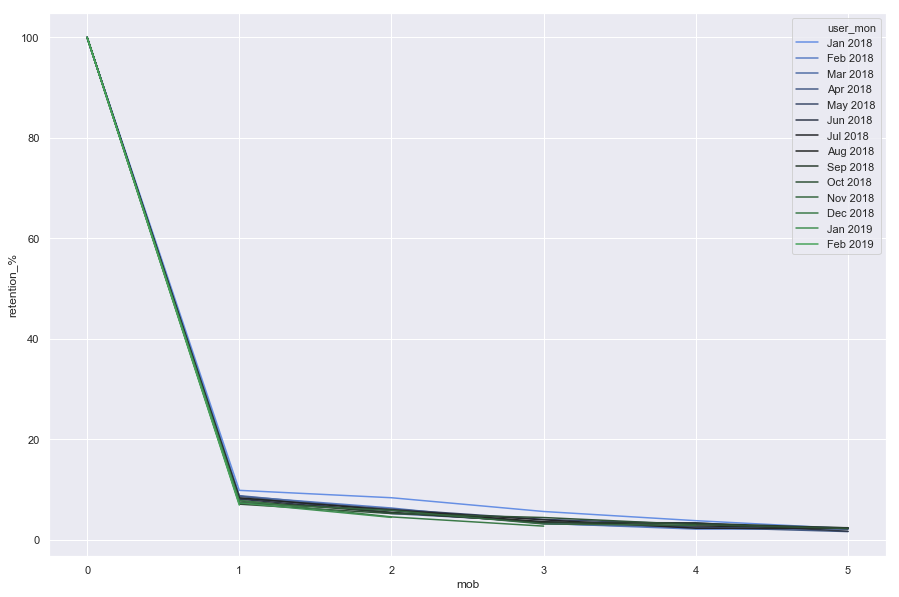

In [65]:
palette = sns.diverging_palette(255, 133, l=60, n=14, center="dark")
sns.lineplot(x='mob',y='retention_%',data=df_shopify_retention[df_shopify_retention['mob'] <=5],
             hue='user_mon', palette=palette)

In [66]:
#Shopify users monthly transaction retention tables
df_shopify_retention = df_shopify_retention.pivot_table(values='retention_%', index=['user_month'],columns=['mob'])
df_shopify_retention = df_shopify_retention.reset_index().set_index('user_month')
df_shopify_retention

mob,0,1,2,3,4,5,6,7,8,9,10,11,12,14,16
user_month,,,,,,,,,,,,,,,
2018-01-01,100.0,9.837728,8.367140,5.628803,3.803245,2.231237,2.180527,2.129817,0.811359,1.166329,1.014199,0.557809,1.014199,0.862069,0.709939
2018-02-01,100.0,8.657335,6.324520,3.265941,2.125454,2.125454,2.021773,0.725765,0.984966,0.673924,0.259202,0.933126,0.259202,0.622084,NaN
2018-03-01,100.0,8.790289,5.902051,3.223106,2.385936,2.385936,1.339473,1.339473,1.255756,0.795312,0.837170,0.837170,0.544161,NaN,NaN
2018-04-01,100.0,8.684760,5.219207,3.590814,2.505219,1.628392,1.544885,1.377871,0.835073,1.336117,0.793319,0.668058,NaN,NaN,NaN
2018-05-01,100.0,8.227115,6.102742,4.055620,3.089996,2.162997,1.660873,1.197374,1.313248,1.042874,0.579374,NaN,NaN,NaN,NaN
2018-06-01,100.0,8.084772,5.455259,3.453689,3.375196,1.687598,1.216641,1.491366,0.667190,0.863422,NaN,NaN,NaN,NaN,NaN
2018-07-01,100.0,7.381306,5.897626,3.968843,2.299703,2.262611,2.225519,1.520772,1.075668,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01,100.0,8.347826,5.878261,3.582609,2.747826,2.400000,1.634783,1.252174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,100.0,7.754801,5.428360,3.434269,3.286558,2.363368,1.587888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


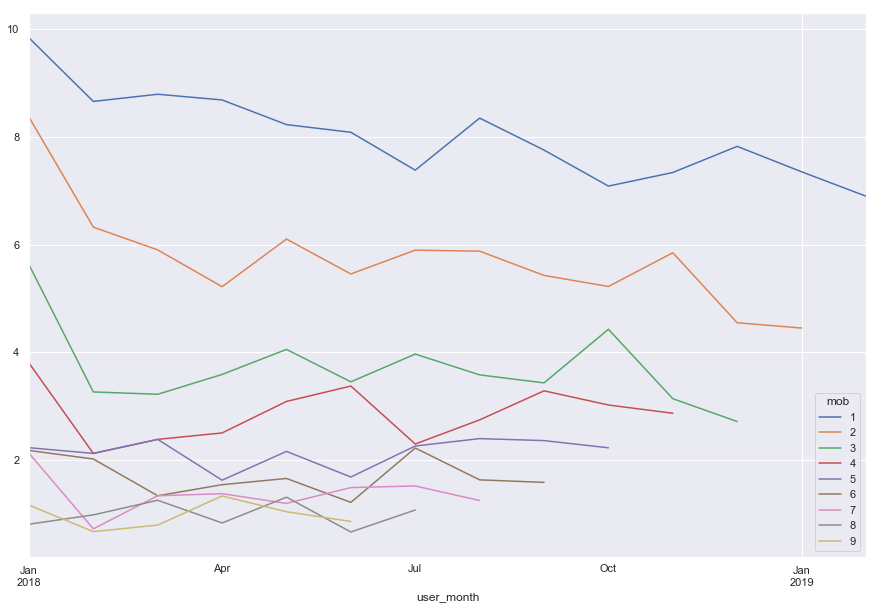

In [70]:
df_shopify_retention.iloc[:,1:10].plot()

+ Hello Baby Box orders have a retention rate of ~100% of the users in the month of order i.e. They order once and are pretty much done.
+ For Shopify orders, it's an interesting retention curve over time. The Month 1 to 6 retention rate has been decreasing since Jan 2018.
    + Once the zeroth month transaction is done, only ~8% of the users transact again in the next month.
    + By Month 2 it is down to 5.7% and by Month 3 it is down to 3.5%, on an average.
    + By Month 7-8 we hardly have any users coming back to make a purchase
+ The high Month 0 retention rates can be a good and bad thing. For e.g., 
    + it is really good that 100% customers are transacting in the first month and providing a revenue stream.
    + it is kind of okay if we are thinking of the stickiness of these users are actually declining over time.
+ This gives us the What, however for the Why behind this behaviour would require more research into what kind of audiences were signed up in those cohorts etc.

## Potential project next steps:
+ Look at Daily retention curves. If we know the day at which all these users are falling off, we can treat them with marketing campaign email to keep the nudge them towards a purchase.

+ Look at transaction retention curves by sign up cohorts.

+ Find out the likelihood of shipping an order that has fraud hold placed on it? If there is a pattern to the fraud flagged orders that are eventually being shipped and if we can predict it with a high confidence, can the model help reduce shipping time to customers? What would be the average time saved?